<img src="Mars.jpg" alt="The first colored picture sent by Perseverance" width="600"/>

## Familiarize yourself with Gaussian Mixtures

In this lab we will try to feel comfortable with the Expectation Maximization algorithm and its use to fit Gaussian mixture models. To this aim we will start by writing our own EM algorithm for a mixture of univariate Gaussian distributions. We will then complexify our setting by dealing with the multivariate case. We will finally have fun with an application to image segmentation on the first colored picture of Mars sent recently by *Perseverance*.

*Remark: Although we will use the GaussianMixture function of Python for this lab, the current version is not as powerfull as (many) R alternative such as packages *mclust* or *Rmixmod*. For instance, such R packages allows for much more covariance structure configurations than the GaussianMixture. If you want to dive seriously into the Gaussian mixture model worlds, these software are top notch!*

### Univariate case

We consider the following mixture model
$$f(y) = \sum_{k=1}^K \tau_k \varphi(y; \mu_k, \sigma^2_k), \qquad k \geq 1,$$
where $\varphi(\cdot, \mu, \sigma^2)$ denotes the p.d.f. of a normal distribution with mean $\mu$ and variance $\sigma^2$ and $\tau_k$ are the cluster membership probabilities, i.e., $\tau_k \geq 0$ and $\sum_{k} \tau_k = 1$.

In [32]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

In [2]:
path = os.getcwd()
os.listdir(os.curdir)

['.git',
 '.ipynb_checkpoints',
 'Mixture Model Lab.ipynb',
 'README.md',
 'resultats-par-niveau-reg-t1-france-entiere.xlsx']

In [3]:
col_commun=['Code de la région','Libellé de la région','Etat saisie','Inscrits',
     'Abstentions','% Abs/Ins','Votants','% Vot/Ins','Blancs','% Blancs/Ins',
     '% Blancs/Vot','Nuls','% Nuls/Ins','% Nuls/Vot','Exprimés','% Exp/Ins',
     '% Exp/Vot']
col_spec=['Sexe','Nom','Prénom','Voix','% Voix/Ins','% Voix/Exp']

nom_cols = []
for i in range(89):
    if i < len(col_commun):
        nom = col_commun[i]
    else:
        j = (i-len(col_commun)) % len(col_spec)
        k = (i-len(col_commun)) // len(col_spec)
        nom = col_spec[j] + " " + str(k)
    nom_cols.append(nom)
np.array(nom_cols)

array(['Code de la région', 'Libellé de la région', 'Etat saisie',
       'Inscrits', 'Abstentions', '% Abs/Ins', 'Votants', '% Vot/Ins',
       'Blancs', '% Blancs/Ins', '% Blancs/Vot', 'Nuls', '% Nuls/Ins',
       '% Nuls/Vot', 'Exprimés', '% Exp/Ins', '% Exp/Vot', 'Sexe 0',
       'Nom 0', 'Prénom 0', 'Voix 0', '% Voix/Ins 0', '% Voix/Exp 0',
       'Sexe 1', 'Nom 1', 'Prénom 1', 'Voix 1', '% Voix/Ins 1',
       '% Voix/Exp 1', 'Sexe 2', 'Nom 2', 'Prénom 2', 'Voix 2',
       '% Voix/Ins 2', '% Voix/Exp 2', 'Sexe 3', 'Nom 3', 'Prénom 3',
       'Voix 3', '% Voix/Ins 3', '% Voix/Exp 3', 'Sexe 4', 'Nom 4',
       'Prénom 4', 'Voix 4', '% Voix/Ins 4', '% Voix/Exp 4', 'Sexe 5',
       'Nom 5', 'Prénom 5', 'Voix 5', '% Voix/Ins 5', '% Voix/Exp 5',
       'Sexe 6', 'Nom 6', 'Prénom 6', 'Voix 6', '% Voix/Ins 6',
       '% Voix/Exp 6', 'Sexe 7', 'Nom 7', 'Prénom 7', 'Voix 7',
       '% Voix/Ins 7', '% Voix/Exp 7', 'Sexe 8', 'Nom 8', 'Prénom 8',
       'Voix 8', '% Voix/Ins 8', '% Voix/Exp 8'

In [24]:
#path = "resultats-par-niveau-reg-t1-france-entiere.xlsx"
#pd.read_csv(path, sep=";", encoding="latin")

url = "https://www.data.gouv.fr/fr/datasets/r/cbf026c5-e0bf-4ff8-b1cd-eb994cd26290"

data = pd.read_csv(url, sep=";",encoding="latin", header=0, names=nom_cols)
data2 = data[['% Abs/Ins', '% Vot/Ins',
       '% Blancs/Ins', '% Blancs/Vot', '% Nuls/Ins',
       '% Nuls/Vot', '% Exp/Ins', '% Exp/Vot', '% Voix/Ins 0', '% Voix/Exp 0',
       '% Voix/Ins 1', '% Voix/Exp 1',
       '% Voix/Ins 2', '% Voix/Exp 2',
       '% Voix/Ins 3', '% Voix/Exp 3',
       '% Voix/Ins 4', '% Voix/Exp 4', 
       '% Voix/Ins 5', '% Voix/Exp 5',
       '% Voix/Ins 6', '% Voix/Exp 6',
       '% Voix/Ins 7', '% Voix/Exp 7', 
       '% Voix/Ins 8', '% Voix/Exp 8', 
       '% Voix/Ins 9', '% Voix/Exp 9', 
       '% Voix/Ins 10', '% Voix/Exp 10',
       '% Voix/Ins 11', '% Voix/Exp 11']].stack().str.replace(',','.').unstack()

In [42]:
data2

,% Abs/Ins,% Vot/Ins,% Blancs/Ins,% Blancs/Vot,% Nuls/Ins,% Nuls/Vot,% Exp/Ins,% Exp/Vot,% Voix/Ins 0,% Voix/Exp 0,...,% Voix/Ins 7,% Voix/Exp 7,% Voix/Ins 8,% Voix/Exp 8,% Voix/Ins 9,% Voix/Exp 9,% Voix/Ins 10,% Voix/Exp 10,% Voix/Ins 11,% Voix/Exp 11
0,26.10,73.90,1.09,1.48,0.48,0.65,72.32,97.87,0.48,0.67,...,1.04,1.43,2.90,4.01,3.13,4.33,0.58,0.80,1.94,2.68
1,21.57,78.43,1.20,1.53,0.61,0.77,76.63,97.70,0.41,0.54,...,1.73,2.26,3.40,4.44,3.52,4.60,0.73,0.95,1.52,1.98
2,22.10,77.90,1.26,1.62,0.46,0.59,76.18,97.79,0.42,0.55,...,1.40,1.83,4.04,5.31,3.92,5.15,0.55,0.72,1.77,2.33
3,22.92,77.08,1.32,1.72,0.58,0.76,75.17,97.52,0.53,0.71,...,1.33,1.77,3.02,4.02,3.85,5.12,0.64,0.85,1.94,2.58
4,21.21,78.79,1.24,1.58,0.52,0.66,77.03,97.76,0.51,0.66,...,1.70,2.21,4.77,6.19,3.62,4.70,0.78,1.01,1.37,1.78
5,25.01,74.99,1.26,1.69,0.51,0.68,73.22,97.64,0.50,0.69,...,1.26,1.72,2.96,4.04,3.90,5.33,0.61,0.83,1.73,2.36
6,23.96,76.04,1.04,1.37,0.38,0.50,74.62,98.13,0.30,0.40,...,1.07,1.43,4.03,5.40,4.62,6.19,0.45,0.60,1.19,1.59
7,21.75,78.25,1.11,1.42,0.58,0.74,76.57,97.85,0.34,0.45,...,1.78,2.33,3.22,4.20,2.99,3.90,0.55,0.72,1.46,1.91
8,26.94,73.06,1.01,1.38,0.57,0.78,71.48,97.84,0.49,0.69,...,0.96,1.34,2.24,3.13,2.53,3.53,0.50,0.69,1.30,1.82
9,24.48,75.52,1.20,1.59,0.44,0.58,73.89,97.83,0.53,0.72,...,1.25,1.70,3.04,4.11,3.31,4.47,0.66,0.90,1.60,2.16


In [66]:
tp = data2.get(["% Voix/Exp 0", "% Voix/Exp 1", "% Voix/Exp 2", "% Voix/Exp 3", "% Voix/Exp 4", "% Voix/Exp 5", "% Voix/Exp 6",
                "% Voix/Exp 7", "% Voix/Exp 7", "% Voix/Exp 8", "% Voix/Exp 9", "% Voix/Exp 10", "% Voix/Exp 11",
               "% Voix/Ins 0", "% Voix/Ins 1", "% Voix/Ins 2", "% Voix/Ins 3", "% Voix/Ins 4", "% Voix/Ins 5", "% Voix/Ins 6",
                "% Voix/Ins 7", "% Voix/Ins 7", "% Voix/Ins 8", "% Voix/Ins 9", "% Voix/Ins 10", "% Voix/Ins 11"])
x = tp.to_numpy(dtype=float)
print(x)

[[ 0.67  1.7  27.28  2.77 29.54  7.17 17.63  1.43  1.43  4.01  4.33  0.8
   2.68  0.48  1.23 19.73  2.   21.36  5.18 12.75  1.04  1.04  2.9   3.13
   0.58  1.94]
 [ 0.54  2.83 27.64  5.9  22.8   6.15 19.92  2.26  2.26  4.44  4.6   0.95
   1.98  0.41  2.17 21.18  4.52 17.47  4.72 15.26  1.73  1.73  3.4   3.52
   0.73  1.52]
 [ 0.55  2.28 27.75  3.22 22.28  7.39 21.2   1.83  1.83  5.31  5.15  0.72
   2.33  0.42  1.73 21.14  2.45 16.97  5.63 16.15  1.4   1.4   4.04  3.92
   0.55  1.77]
 [ 0.71  2.27 26.31  3.31 27.35  7.15 18.56  1.77  1.77  4.02  5.12  0.85
   2.58  0.53  1.7  19.78  2.49 20.56  5.37 13.95  1.33  1.33  3.02  3.85
   0.64  1.94]
 [ 0.66  2.59 32.79  2.97 19.53  4.91 20.65  2.21  2.21  6.19  4.7   1.01
   1.78  0.51  2.   25.26  2.29 15.04  3.79 15.91  1.7   1.7   4.77  3.62
   0.78  1.37]
 [ 0.69  2.5  28.53  2.87 25.86  6.58 18.68  1.72  1.72  4.04  5.33  0.83
   2.36  0.5   1.83 20.89  2.1  18.93  4.82 13.68  1.26  1.26  2.96  3.9
   0.61  1.73]
 [ 0.4   1.92 30.19  1.5

In [55]:
tp

,% Voix/Exp 0,% Voix/Exp 1,% Voix/Exp 2,% Voix/Exp 3,% Voix/Exp 4,% Voix/Exp 5,% Voix/Exp 6,% Voix/Exp 7,% Voix/Exp 7,% Voix/Exp 8,...,% Voix/Ins 3,% Voix/Ins 4,% Voix/Ins 5,% Voix/Ins 6,% Voix/Ins 7,% Voix/Ins 7,% Voix/Ins 8,% Voix/Ins 9,% Voix/Ins 10,% Voix/Ins 11
0,0.67,1.70,27.28,2.77,29.54,7.17,17.63,1.43,1.43,4.01,...,2.00,21.36,5.18,12.75,1.04,1.04,2.90,3.13,0.58,1.94
1,0.54,2.83,27.64,5.90,22.80,6.15,19.92,2.26,2.26,4.44,...,4.52,17.47,4.72,15.26,1.73,1.73,3.40,3.52,0.73,1.52
2,0.55,2.28,27.75,3.22,22.28,7.39,21.20,1.83,1.83,5.31,...,2.45,16.97,5.63,16.15,1.40,1.40,4.04,3.92,0.55,1.77
3,0.71,2.27,26.31,3.31,27.35,7.15,18.56,1.77,1.77,4.02,...,2.49,20.56,5.37,13.95,1.33,1.33,3.02,3.85,0.64,1.94
4,0.66,2.59,32.79,2.97,19.53,4.91,20.65,2.21,2.21,6.19,...,2.29,15.04,3.79,15.91,1.70,1.70,4.77,3.62,0.78,1.37
5,0.69,2.50,28.53,2.87,25.86,6.58,18.68,1.72,1.72,4.04,...,2.10,18.93,4.82,13.68,1.26,1.26,2.96,3.90,0.61,1.73
6,0.40,1.92,30.19,1.59,12.97,7.47,30.24,1.43,1.43,5.40,...,1.19,9.68,5.57,22.57,1.07,1.07,4.03,4.62,0.45,1.19
7,0.45,2.52,23.48,5.59,24.63,7.86,22.41,2.33,2.33,4.20,...,4.28,18.86,6.02,17.16,1.78,1.78,3.22,2.99,0.55,1.46
8,0.69,3.12,25.40,2.05,33.34,5.90,18.98,1.34,1.34,3.13,...,1.47,23.83,4.22,13.57,0.96,0.96,2.24,2.53,0.50,1.30
9,0.72,2.60,29.26,2.55,27.14,5.58,18.82,1.70,1.70,4.11,...,1.88,20.06,4.12,13.90,1.25,1.25,3.04,3.31,0.66,1.60


In [ ]:
from sklearn.decomposition import PCA

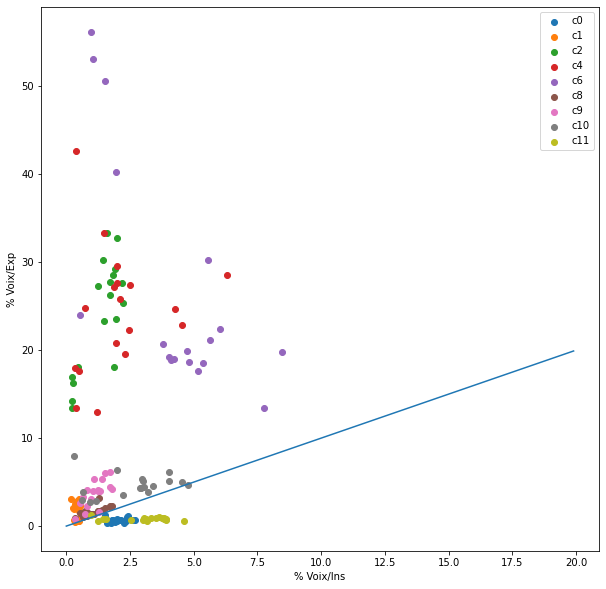

In [58]:
plt.figure(figsize=(10,10))
for i in range(12):
    if i in [3,5,7]:
        continue
    plt.scatter(x[:,12+i],x[:,i], label=f"c{i}")
t=np.arange(0,20,0.1)
plt.plot(t,t)
plt.xlabel("% Voix/Ins")
plt.ylabel("% Voix/Exp")
plt.legend()

In [67]:
x[:,23]

array([3.13, 3.52, 3.92, 3.85, 3.62, 3.9 , 4.62, 2.99, 2.53, 3.31, 3.77,
       3.17, 3.84, 1.26, 1.55, 0.97, 1.44, 3.05])

In [62]:
tp[["% Voix/Exp 11","% Voix/Ins 11"]]

,% Voix/Exp 11,% Voix/Ins 11
0,2.68,1.94
1,1.98,1.52
2,2.33,1.77
3,2.58,1.94
4,1.78,1.37
5,2.36,1.73
6,1.59,1.19
7,1.91,1.46
8,1.82,1.30
9,2.16,1.60


#### Question 1:

Write a function that simulates from this mixture model. Play a bit with your brand new function to see how changing the parameters impacts the structure of the observations.

In [27]:
np.random.normal(scale=np.array([8,1]))

array([-1.49403083, -0.95582518])

In [30]:
def gauss(yi, mu, sigma) :
    return(1/(sigma * np.sqrt(2 * np.pi)) *
               np.exp( - (yi - mu)**2 / (2 * sigma**2) ))

In [31]:
gauss(point[0], mu[0], sigma[0])

array([0.02195823])

In [33]:
sum(mu)

27

In [108]:
tau = [0.2, 0.2, 0.2, 0.2, 0.2]
mu = [1, 5, 13, 6, 2]
sigma = [8, 1, 0.5, 3, 10]
n = 50

point = []
classe = []
for i in range(n) : 
    nb = np.random.choice([0, 1, 2 ,3, 4], p=tau)
    classe.append(nb)
    point.append(np.random.normal(mu[nb], sigma[nb], 1))

point, classe

([array([2.22307849]),
  array([13.70142218]),
  array([-5.8675324]),
  array([12.64497577]),
  array([6.75812897]),
  array([3.88426731]),
  array([3.89525342]),
  array([13.29066445]),
  array([19.12010821]),
  array([12.5651107]),
  array([4.70728456]),
  array([4.87132509]),
  array([7.67757138]),
  array([7.26747298]),
  array([13.24779858]),
  array([5.01534067]),
  array([10.32339551]),
  array([5.65860369]),
  array([8.74373246]),
  array([12.67127004]),
  array([12.65655019]),
  array([6.58766844]),
  array([5.06409995]),
  array([-8.36241023]),
  array([9.17541255]),
  array([2.54559172]),
  array([3.02714109]),
  array([13.89461849]),
  array([12.93181576]),
  array([2.72472237]),
  array([10.55834219]),
  array([13.37327933]),
  array([5.31481558]),
  array([13.69205034]),
  array([9.42364766]),
  array([4.57545784]),
  array([12.74224543]),
  array([-1.96185714]),
  array([-13.83509816]),
  array([7.22616782]),
  array([-2.04739981]),
  array([5.83262385]),
  array([4.7084

#### Question 2:

Write a pseudo code for an EM algorithm on this mixture model and, next, implement it.

In [109]:
I = 0
mu = [1, 1, 1, 1,1]
tau = [0.2, 0.2, 0.2, 0.2, 0.2]
sigma = [1, 1, 1, 1, 1]

while I<4 : 
    
    for g in range(5) :
        tau_cond = []
        for i in range(len(point)) :
            somme = 0
            for k in range(5) : 
                somme = somme + tau[k]*gauss(point[i], mu[k], sigma[k])
            tau_cond.append(tau[g]*gauss(point[i], mu[g], sigma[g])/somme)
        print(I)
        print(tau_cond)
        tau[g] = sum(tau_cond)/len(point)
        
        multi = 0
        for i in range(len(point)):
            multi = multi+tau_cond[i]*point[i]
        mu[g] = multi/sum(tau_cond)
        
        cov = 0
        for i in range(len(point)):
            cov = cov+tau_cond[i]*(point[i]-mu[g])**2
        sigma[g] = cov/sum(tau_cond)
    print("AAAAAAAAAAAA")
    print(tau)
    I = I+1


        
    

0
[array([0.2]), array([0.2]), array([0.2]), array([0.2]), array([0.2]), array([0.2]), array([0.2]), array([0.2]), array([0.2]), array([0.2]), array([0.2]), array([0.2]), array([0.2]), array([0.2]), array([0.2]), array([0.2]), array([0.2]), array([0.2]), array([0.2]), array([0.2]), array([0.2]), array([0.2]), array([0.2]), array([0.2]), array([0.2]), array([0.2]), array([0.2]), array([0.2]), array([0.2]), array([0.2]), array([0.2]), array([0.2]), array([0.2]), array([0.2]), array([0.2]), array([0.2]), array([0.2]), array([0.2]), array([0.2]), array([0.2]), array([0.2]), array([0.2]), array([0.2]), array([0.2]), array([0.2]), array([0.2]), array([0.2]), array([0.2]), array([0.2]), array([0.2])]
0
[array([0.24702233]), array([4.10511631e-34]), array([2.60707979e-09]), array([1.57377372e-28]), array([2.75140858e-06]), array([0.1829403]), array([0.18137018]), array([6.94796407e-32]), array([2.28598151e-70]), array([3.97516886e-28]), array([0.03829217]), array([0.02213225]), array([9.053545

In [110]:
tau

[array([0.05918437]),
 array([0.07188149]),
 array([0.15754609]),
 array([0.39600934]),
 array([0.56676901])]

In [111]:
sigma

[array([75.16806525]),
 array([76.66528877]),
 array([77.30081275]),
 array([71.44180498]),
 array([12.05722521])]

In [71]:
g = 0
for i in range(len(point)) :
            somme = 0
            for g in range(5) : 
                somme = somme + tau[g]*gauss(point[i], mu[g], sigma[g])
            tau_cond.append(tau[g]*gauss(point[i], mu[g], sigma[g])/somme)
a = sum(tau_cond)/len(point)
a

array([0.30922452])

#### Question 3:

Test your EM algorithm on simulated data and show the evolution of the Gaussian mixture estimates as the number of iterations increases.

In [12]:
## Code goes here
## %load solutions/question3.py

#### Question 4:

Modify your EM algorithm so that it also outputs the conditional membership probabilities

$$ t_g(y) = \Pr(Z = g \mid Y = y), \qquad y \in \mathcal{Y}, \quad g \in \{1, \ldots, G\},$$

and, based on your simulated data, predict the class of each observation using maximum a posteriori.

You may consider plotting the data with colors depending on the estimated component, the fitted mixture density and each individuals gaussian densities.

In [15]:
## Code goes here
## %load solutions/question4.py

#### Question 5:

Write a function that predict the class of new observations.

In [18]:
## Code goes here
## %load solutions/question5.py

#### Question 6:

Have a look at the [GaussianMixture](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html) function of the scikitlearn library and learn how to use it. 

Use it on your simulated dataset and compare the output from that of your own function. You may want to:
  + redo the above graphics using the output of GaussianMixture;
  + use the [confusion_matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) function.
  
Are you happy?

In [21]:
## Code goes here
## %load solutions/question6.py

### Going multivariate

#### Question 7:

Have a look at the [make_blobs](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html) function which generate mixture from (very specific) Gaussian distributions. Use this function to generate a sample of size $n=100$ from a Gaussian mixture in $\mathbb{R}^2$ with $G=4$ components.

In [24]:
## Code goes here
## %load solutions/question7.py

#### Question 8:

Use the GaussianMixture function to estimate a Gaussian mixture model on this sample. Give the mathematical details of the model you fit. Give a plot where you show the prediction class in $[-12, 12]^2$ and another plot where you plot the uncertainties in classification. 

In [33]:
## Code goes here
## %load solutions/question8.py

#### Question 9:

Perform model selection by varying the number of mixture components and the covariance structure. Compare prediction from the top two competitive models.

In [36]:
## Code goes here
## %load solutions/question9.py

### Just for fun Image segmentation

Here we will do a small application where we want to perform image segmentation using Gaussian mixture models. Here is a typical roadmap:
  - First get the [first colored image of Mars sent by *Perseverance*](https://mars.nasa.gov/system/resources/detail_files/25612_PIA24430-panorama-1200.jpg) and import it.
  - Then fit a suitable Gaussian mixture model. In doing so, you may want to train your model on a (random) sub-sample of this image.
  - Plot the "segmented" image where you first plot using "non-sense" color palette, i.e., color palette is $\{1, \ldots, G\}$.
  - Refine your color platte by taking it to be $\{\mu_1, \ldots, \mu_G\}$.

In [35]:
## Code goes here
## %load solutions/justForFun.py